# Loads an ensemble of models, applies it to all of the data in a patient's clip (usually an hour), and outputs the classifier results to disk

In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
import pickle
# import re
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import imp 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [3]:
# Function for extracting channel names from filename
def chan_labels_from_fname(in_file):
    just_fname=in_file.split('/')[-1]
    jf_splt=just_fname.split('_')
    chan_label=jf_splt[1]+'-'+jf_splt[2]
    return chan_label

In [4]:
# Get list of electrodes for the subject
def sub_soz_elec_names(sub,ftr_root):
    soz_elec_names=list()
    szr_fname_dict=dict()
    non_elec_names=list()
    
    ftr_path=os.path.join(ftr_root,str(sub))
    for f in os.listdir(ftr_path):
            if f.endswith('non.mat'):
                non_elec_names.append(chan_labels_from_fname(f))
            elif f.endswith('.mat') and f.startswith(str(sub)+'_'):
                temp_label=chan_labels_from_fname(f)
                if temp_label in soz_elec_names:
                    szr_fname_dict[soz_elec_names[-1]].append(f)
                else:
                    soz_elec_names.append(temp_label)
                    szr_fname_dict[temp_label]=[f]
                    
    soz_elec_names=np.unique(soz_elec_names)
    non_elec_names=np.unique(non_elec_names)
    print('%d total # of SOZ electrodes for this sub' % len(soz_elec_names))
        
    return soz_elec_names, szr_fname_dict

In [5]:
# sub=1096
# szr_ftr_root='/home/dgroppe/GIT/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
# soz_elec_list, _=sub_soz_elec_names(sub,szr_ftr_root)
# print(soz_elec_names)

In [17]:
# Get filenames grouped by time chunk
def continuous_fnames(sub, cont_ftr_root, szr_ftr_root):
    #/home/dgroppe/EU_SE_FTRS/1096_all

    # Get list of SOZ electrodes
    soz_elec_names, _=sub_soz_elec_names(sub,szr_ftr_root)
    first_chans=soz_elec_names[0].split('-')
#     print(first_chans)
    
    # Get list of all time clips
    ftr_path=os.path.join(cont_ftr_root,str(sub)+'_all')
    clip_list=list()
#     print(ftr_path)
#     print(str(sub)+'_'+first_chans[0]+'_'+first_chans[1])
    for f in os.listdir(ftr_path):
        if f.startswith(str(sub)+'_'+first_chans[0]+'_'+first_chans[1]):
            stem=f.split('.')[0]
            splt_stem=stem.split('_')
            clip_list.append(splt_stem[3]+'_'+splt_stem[4])
            
    # Loop over soz electrodes and make sure time chunk exists for each electrode
    flag=False
    for chan in soz_elec_names[1:]: #skip first electrode because we know files exist
        mono_chans=chan.split('-')
        for clip in clip_list:
            fname=str(sub)+'_'+mono_chans[0]+'_'+mono_chans[1]+'_'+clip+'.mat'
            f=os.path.join(ftr_path,fname)
            if os.path.isfile(f)==False:
                print('Error: missing file %s' % f)
                flag=True
    if flag==False:
        print('All files accounted for. Proceed.')
        
    return clip_list, soz_elec_names

In [106]:
# Get list of files
sub=1096
# cont_ftr_root='/home/dgroppe/EU_SE_FTRS/'
# szr_ftr_root='/home/dgroppe/GIT/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
cont_ftr_root='/Users/davidgroppe/ONGOING/EU_SE_FTRS/'
szr_ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
clip_list, soz_elec_names=continuous_fnames(sub, cont_ftr_root, szr_ftr_root)
n_chan=len(soz_elec_names)
print('# of clips %d' % len(clip_list))

8 total # of SOZ electrodes for this sub
All files accounted for. Proceed.
# of clips 4


In [107]:
# Load models
#model_name='genSvmSe_3'
model_name='genLogregSe_3'
#model_type='svm'
model_type='logreg'
#model_fname=os.path.join('/home/dgroppe/GIT/SZR_ANT/MODELS/',model_name,'classify_models_srch.pkl')
model_fname=os.path.join('/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/',model_name,'classify_models_srch.pkl')
models=pickle.load(open(model_fname,'rb'))
n_models=len(models)
print('# of models= %d' % n_models)

# tpt span of moving windo via which to smooth p(stim)
mv_wind_len=20 # Sampling rate should 10 Hz

# Outpath
out_root='/Users/davidgroppe/ONGOING/EU_YHAT/'
out_path=os.path.join(out_root,str(sub)+'_'+model_name)
if os.path.exists(out_path)==False:
    os.mkdir(out_path)

# Load params for normalization
subsamp_ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
#subsamp_ftr_root='/home/dgroppe/GIT/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
subsamp_ftr_path=os.path.join(subsamp_ftr_root,str(sub))
mns_dict=dict()
sds_dict=dict()
for chan in soz_elec_names:
    mono_chans=chan.split('-')
    nonszr_fname=str(sub)+'_'+mono_chans[0]+'_'+mono_chans[1]+'_non.mat'
    #print('Loading %s' % 
    temp_ftrs=sio.loadmat(os.path.join(subsamp_ftr_path,nonszr_fname))
    # Z-score features
    temp_mns, temp_sds=dg.trimmed_normalize(temp_ftrs['nonszr_se_ftrs'],0,
                                            zero_nans=False,verbose=False)
    mns_dict[chan]=temp_mns
    sds_dict[chan]=temp_sds

# plt.figure(1)
# plt.clf()
    
# Loop over clips
#for clip in clip_list[:1]:
for clip in clip_list:
    print('Working on clip %s' % clip)
    # Loop over SOZ electrodes
    for chan_ct, chan in enumerate(soz_elec_names):
        mono_chans=chan.split('-')
        # Load features
        fname=str(sub)+'_'+mono_chans[0]+'_'+mono_chans[1]+'_'+clip+'.mat'
        f=os.path.join(cont_ftr_root,str(sub)+'_all',fname)
        temp_mat=sio.loadmat(f)

        # Estimate p(szr)
        raw_ftrs=temp_mat['se_ftrs']
        # Z-score based on non-ictal means, SDs
        dg.applyNormalize(raw_ftrs,mns_dict[chan],sds_dict[chan])
        # Apply classifiers
        for model_ct in range(n_models):
            if model_type=='svm':
                tmp_yhat_va = models[model_ct].predict(raw_ftrs.T)[:,1]
            else:
                tmp_yhat_va = models[model_ct].predict_proba(raw_ftrs.T)[:,1]
            if model_ct==0:
                yhat=np.zeros(tmp_yhat_va.shape)
            yhat+=tmp_yhat_va/n_models
        
        # Smooth p(szr)
        yhat_smooth=np.zeros(yhat.shape)
        yhat_smooth[mv_wind_len-1:]=dg.running_mean(yhat,mv_wind_len)
#         plt.plot(yhat_smooth,label=chan)
        
#         if chan=='HL6-HL7':
#         #if chan=='HL5-HL6':
#             yhat_check=np.copy(yhat_smooth)
#             yhat_sec=temp_mat['se_time_sec']
#             ieeg_check=temp_mat['ieeg']
#             ieeg_sec=temp_mat['time_dec']
        
        # Collect max(p(szr)) for each time window
        if chan_ct==0:
            # first channel
            max_yhat=np.copy(yhat_smooth)
            yhat_soz_chans=np.zeros((n_chan,len(yhat_smooth)))
        else:
            max_yhat=np.maximum(max_yhat,yhat_smooth)
        yhat_soz_chans[chan_ct,:]=yhat_smooth
    
    # Write to disk
    out_fname=clip+'_yhat'
    print('Saving yhat to %s' % os.path.join(out_path,out_fname))
    np.savez(os.path.join(out_path,out_fname),
                 max_yhat=max_yhat,
                 yhat_soz_chans=yhat_soz_chans,
                 yhat_sec=temp_mat['se_time_sec']) #note that time is relative to start of file (i.e., 0=first file tpt)
    
# plt.legend()
print('Done')

# of models= 5
Working on clip 109600102_0000
Saving yhat to /Users/davidgroppe/ONGOING/EU_YHAT/1096_genLogregSe_3/109600102_0000_yhat
Working on clip 109600102_0001
Saving yhat to /Users/davidgroppe/ONGOING/EU_YHAT/1096_genLogregSe_3/109600102_0001_yhat
Working on clip 109600102_0002
Saving yhat to /Users/davidgroppe/ONGOING/EU_YHAT/1096_genLogregSe_3/109600102_0002_yhat
Working on clip 109600102_0072
Saving yhat to /Users/davidgroppe/ONGOING/EU_YHAT/1096_genLogregSe_3/109600102_0072_yhat
Done


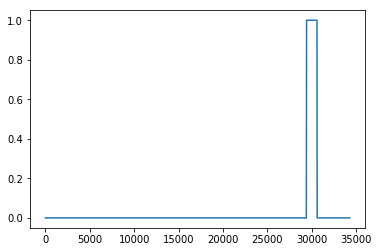

In [109]:
temp_f='/Volumes/SgateOSExJnld/EU_TEMP/1096_all_labels/1096_y_109600102_0072.mat';
bro=sio.loadmat(temp_f)
bro.keys()

plt.figure(1)
plt.clf()
plt.plot(np.squeeze(bro['se_szr_class']))

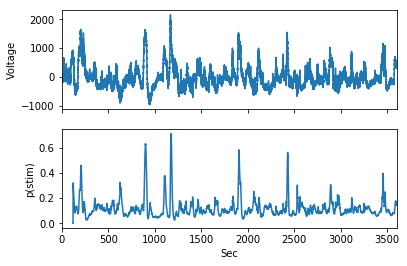

In [111]:
xlim=[ieeg_sec[0,0], ieeg_sec[0,-1]]
# xlim=[1100, 1250]
# xlim=[600, 1200]
# plt.figure(2)
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
ax[0].plot(np.squeeze(ieeg_sec),np.squeeze(ieeg_check))
ax[0].set_xlim(xlim)
ax[0].set_ylabel('Voltage')

ax[1].plot(np.squeeze(yhat_sec),np.squeeze(yhat_check))
ax[1].set_xlabel('Sec')
ax[1].set_ylabel('p(stim)')

In [63]:
ieeg_sec.shape
ieeg_sec[0,-1]

3599.99755859375

In [52]:
ieeg_check.shape

(1, 921600)

In [48]:
print(temp_mat.keys())
temp_mat['se_time_sec'][:,1]-temp_mat['se_time_sec'][:,0]

dict_keys(['__version__', 'se_ftrs', 'se_szr_class', '__globals__', 'se_class', '__header__', 'ftr_labels', 'se_time_sec', 'time_dec', 'ieeg'])


array([ 0.1015625])

In [27]:
bro=np.zeros(yhat.shape)
sis=np.maximum(max_yhat,bro)

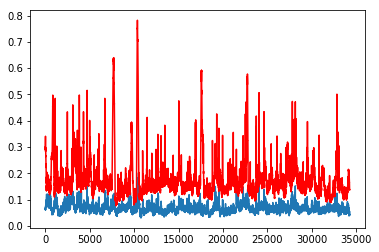

In [36]:
plt.figure(1)
plt.clf()
plt.plot(yhat)
plt.plot(max_yhat,'r-')

In [ ]:
temp_flist=['/Volumes/SgateOSExJnld/EU_TEMP/1096_all/1096_HL2_HL3_109600102_0002.mat']

In [ ]:
# Load saved models
model_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/genLogregSe_3/classify_models_srch.pkl'
models=pickle.load(open(model_fname,'rb'))
n_models=len(models)
print('# of models= %d' % n_models)

In [ ]:
sub=1096
model_name='genLogregSe'
yhat_dir=os.path.join('/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/',model_name+'_yhat')
ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
# Get list of electrodes
soz_elec_names, szr_fname_dict=sub_soz_elec_names(sub,ftr_root)
ftr_path=os.path.join(ftr_root,str(sub))
for elec in soz_elec_names[:1]:
    # load non szr file
    uni_chans=elec.split('-')
    nonszr_fname=str(sub)+'_'+uni_chans[0]+'_'+uni_chans[1]+'_non.mat'
    #print('Loading %s' % nonszr_fname)
    temp_ftrs=sio.loadmat(os.path.join(ftr_path,nonszr_fname))
    # Z-score features
    temp_mns, temp_sds=dg.trimmed_normalize(temp_ftrs['nonszr_se_ftrs'],0,zero_nans=False,verbose=False)
    
    # get list of szr files
    for szr_f in temp_flist:
    #for szr_f in szr_fname_dict[elec]:
        #load file
#         print('Loading %s' % szr_f)
        #temp_ftrs=sio.loadmat(os.path.join(ftr_path,szr_f))
        temp_ftrs=sio.loadmat(szr_f)
        raw_ftrs=temp_ftrs['se_ftrs']
        # Z-score based on non-ictal means, SDs
        dg.applyNormalize(raw_ftrs,temp_mns,temp_sds)
        
        # Apply classifiers
        for model_ct in range(n_models):
            tmp_yhat_va = models[model_ct].predict_proba(raw_ftrs.T)[:,1]
            if model_ct==0:
                yhat=np.zeros(tmp_yhat_va.shape)
            yhat+=tmp_yhat_va/n_models
#         out_fname=str(sub)+'_'+uni_chans[0]+'_'+uni_chans[1]+'_phat_'+szr_f.split('_')[-1]
#         print('Saving file as %s' % out_fname)
#         sio.savemat(os.path.join(yhat_dir,out_fname), mdict={'yhat': yhat,
#                                                              'model_name': model_name,
#                                                              'ftr_fname': szr_f})

print('done')

In [ ]:
print(temp_ftrs.keys())
print(temp_ftrs['se_time_sec'].shape)
print(temp_ftrs['se_ftrs'].shape)
print(tmp_yhat_va.shape)
yhat.shape

In [ ]:
plt.figure(1)
plt.plot(np.squeeze(temp_ftrs['se_time_sec']),yhat)
plt.plot(np.squeeze(temp_ftrs['se_time_sec']),np.squeeze(temp_ftrs['se_szr_class']),'r-')

plt.figure(2)
plt.plot(np.squeeze(np.squeeze(temp_ftrs['time_dec'])),np.squeeze(temp_ftrs['ieeg']))

In [ ]:
temp_ftrs.keys()